# **I. Introduction**

## A. Needs

In [110]:
# Clustering need, with texte data and pictures data.

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## B. Imports

### 0 pre-imports

In [112]:
!pip install opencv-python-headless==4.1.2.30

### 1 Complete imports

In [113]:
import cv2
import datetime as dt
import itertools
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import statistics as stat
import time

### 2 Partial imports

In [114]:
# Classical libraries
from collections import Counter
from difflib import SequenceMatcher

# Data science libraries
from google.colab.patches import cv2_imshow

from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer

from PIL import Image, ImageFilter, ImageOps

from scipy import ndimage as ndi

from skimage import feature
from skimage import filters
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import random_noise

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances
from sklearn.manifold import TSNE, LocallyLinearEmbedding, MDS
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.text import TSNEVisualizer

### 3 Options

In [115]:
# NLTK
nltk.download('stopwords')
pd.options.display.max_info_columns = 50
pd.options.display.precision = 5
sns.set_theme(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## C. Uploading

### 0 Functions

In [116]:
def upload_csv(path, file, df, df_name):
    ''' Functions that read a csv file and returns a pandas dataframe.'''
    df = pd.read_csv(path + file, sep=',')
    df.name = df_name
    return df

### 1 Uploading

In [117]:
# Constants
PATH = 'drive/My Drive/Colab Notebooks/ocr_data_scientist/P6 Classification automatique/'
PATH_TEXT = PATH + 'Flipkart/'
FILE_TEXT = 'flipkart_com-ecommerce_sample_1050.csv'
PATH_PICTURE = PATH + 'Flipkart/Images/'

# CSV data extraction
items_df = upload_csv(path=PATH_TEXT, file=FILE_TEXT,
                      df='items_df', df_name='Items')

In [118]:
!pip install pipreqs
!pipreqs /drive/My Drive/Colab Notebooks/ocr_data_scientist/P6 Classification automatique/

Usage:
    pipreqs [options] [<path>]


In [119]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [120]:
!pip freeze > PATH+requirements.txt

# **II. EDA**

## A. Exploration

### 0 Functions

In [121]:
def nan_proportion(df):
    ''' Returns the proportion of NaN values in the whole dataframe.'''
    nan_proportion_ = df.isna().sum().sum() / (df.shape[0]*df.shape[1]) * 100
    return nan_proportion_

In [122]:
def get_pareto(df, column, filter=10, y_inf=0, y_sup=3500, x_inf=0, x_sup=1000):
    '''Function that takes a list and returns a bar graph of the most common elements of the list.'''
    ratio = math.sqrt(my_filter * 2)
    if df[column].dtype != object:
        plt.figure( figsize=(ratio, ratio))
        ax = plt.axes()
        ax.yaxis.grid()
        plt.xlim((x_inf, x_sup))
        plt.ylim((y_inf, y_sup))
        plt.title('{} - {}'.format(column, df.name))
        plt.hist(df[column],
                 bins=int(df.shape[0]/50),
                 color='blue', edgecolor='black')
    #
    temp_counter = Counter(df[column]).most_common(filter)
    categories, frequencies = zip(*temp_counter)
    frequencies = [value/df.shape[1]*100 for value in frequencies]
    temp_df = pd.DataFrame({'Categories':categories, 'Frequencies':frequencies}).dropna()
    categories = [element for element in temp_df['Categories']]
    frequencies= [element for element in temp_df['Frequencies']]
    #
    plt.figure(figsize=(ratio, ratio))
    plt.title('Fréquence d\'apparition des {}. {} '
              'premiers éléments'.format(column, filter))
    if max(frequencies) > 5:
        plt.xlim((0, 110))
    else:
        plt.xlim((0, max(frequencies)*1.1))
    plt.xlabel('Occurrences en % de la taille de l\'échantillon')
    plt.ylabel('Catégories')
    ax = plt.axes()
    ax.xaxis.grid()
    try:
        plt.barh(categories, frequencies,
                 color='orange', edgecolor='k')
    except TypeError:
        return categories, frequencies

In [123]:
def get_non_nan(df, df_name=''):
    '''Représenter les données non-NaN pour chaque colonne.'''
    # Proportion of non-Nan values
    for column in df.columns:
        temp_dict[column] = df[column].notna().sum()
    tuples_list = sorted(temp_dict.items(),
                         key=lambda item: item[1],
                         reverse=False)
    t_keys = [item[0] for item in tuples_list]
    t_values = [item[1]/df.shape[0]*100 for item in tuples_list]
    # Determine the color of the bars according to the type of the data
    try:
        if df[column].dtype != object:
            color_ = 'blue'
            title_ = 'Proportion de données non-Nan quantitatives ' + df_name
        else:
            color_ = 'orange'
            title_ = 'Proportion de données non-Nan qualitatives ' + df_name
    except UnboundLocalError:
        return print('Dataframe vide')
    # Plot
    plt.figure(figsize=(5, math.sqrt(3*len(t_keys))))
    plt.xlim((0, 110))
    ax = plt.axes()
    ax.xaxis.grid()
    plt.title('{} ({})'.format(title_, len(tuples_list)))
    plt.barh(t_keys, t_values,
             color=color_, edgecolor='k')



In [124]:
def control_chart(df, year, x_feature, y_feature, y_min, y_max,
                  per_week=True, per_month=False, quantiles=False):
    df = merge_df[[x_feature, y_feature]]
    # Outliers
    if quantiles:
        df = df[df[y_feature] < df[y_feature].quantile(.99)]
        df = df[df[y_feature] > df[y_feature].quantile(.01)]
    df = df.groupby([x_feature]).mean()
    df = df.reset_index()
    df[x_feature] = pd.to_datetime(df[x_feature])
    if year:
        mask = df[x_feature].dt.year == int(year)
        df = df[mask]
    # Groupby
    if per_week:
        df[x_feature] = [element.isocalendar()[1] for element
                                   in df[x_feature]]
        df = df.groupby([x_feature]).mean()
        df = df.reset_index()
    if per_month:
        df[x_feature] = df[x_feature].dt.month
        df = df.groupby([x_feature]).mean()
        df = df.reset_index()
    # Average and control lines
    feature_mean = df[y_feature].mean()
    df['feature_mean'] = [feature_mean] * len(df)
    feature_stdev = df[y_feature].std()
    df['feature_ucl'] = df['feature_mean'] + 3 * feature_stdev
    df['feature_lcl'] = df['feature_mean'] - 3 * feature_stdev
    # Plot
    f, ax = plt.subplots(figsize=(8, 8))
    plt.title('{}, année {}'.format(y_feature, year))
    plt.xlabel('Semaines calendaires')
    plt.ylabel(y_feature)
    plt.ylim(y_min, y_max)
    plot_feature = plt.plot(df[x_feature], df[y_feature],
                            'c', linewidth=1, marker='o', color='k', markerfacecolor='orange', markersize=8)
    plot_mean = plt.plot(df[x_feature], df['feature_mean'],
                         'k', linewidth=3)
    plot_ucl = plt.plot(df[x_feature], df['feature_ucl'],
                        '--', color='k')
    plot_lcl = plt.plot(df[x_feature], df['feature_lcl'],
                        '--', color='k')
    plt.show()



In [125]:
def column_most_common_words(df, column, threshold=20):
    product_names = []
    for element in df[column].unique():
        if type(element) == str:
            for word in element.split(' '):
                product_names.append(word)
    # Stopwords
    sw = set()
    sw.update('stopwords')
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    product_names = [element.lower() for element in product_names
                    if element.lower() not in sw
                    and element.isalpha() == True]
    counter = Counter(product_names)
    product_names_df = pd.DataFrame({'word':dict(counter).keys(),
                                     'count':dict(counter).values()})
    product_names_df.sort_values(by='count', inplace=True, ascending=False)
    # Plot
    plt.title('Most 20 common unigrams in {}'.format(column))
    plt.barh(product_names_df['word'][:threshold],
             product_names_df['count'][:threshold])

### 1 General

In [126]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [127]:
items_df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


In [128]:
items_df[['crawl_timestamp', 'product_name', 'product_category_tree',
          'retail_price', 'discounted_price', 'description', 'brand',
          'product_specifications']].head(10)

,crawl_timestamp,product_name,product_category_tree,retail_price,discounted_price,description,brand,product_specifications
0,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",1899.0,899.0,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",600.0,449.0,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",NaN,NaN,Key Features of Eurospa Cotton Terry Face Towe...,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,2016-06-20 08:49:52 +0000,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2699.0,1299.0,Key Features of SANTOSH ROYAL FASHION Cotton P...,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,2016-06-20 08:49:52 +0000,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",2599.0,698.0,Key Features of Jaipur Print Cotton Floral Kin...,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
5,2015-12-04 07:25:36 +0000,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",24400.0,24400.0,Maserati Time R8851116001 Analog Watch - For ...,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
6,2015-12-04 07:25:36 +0000,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",1099.0,449.0,"Camerii WM64 Elegance Analog Watch - For Men,...",NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
7,2015-12-04 07:25:36 +0000,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",999.0,399.0,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
8,2015-12-04 07:25:36 +0000,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >> Wrist Watches >> Alfajr Wrist Wat...",5495.0,4995.0,"Alfajr WY16B Youth Digital Watch - For Men, B...",NaN,"{""product_specification""=>[{""key""=>""Chronograp..."
9,2015-12-04 07:25:36 +0000,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,"[""Watches >> Wrist Watches >> TAG Heuer Wrist ...",107750.0,107750.0,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,NaN,"{""product_specification""=>[{""key""=>""Chronograp..."


### 2 retail_price

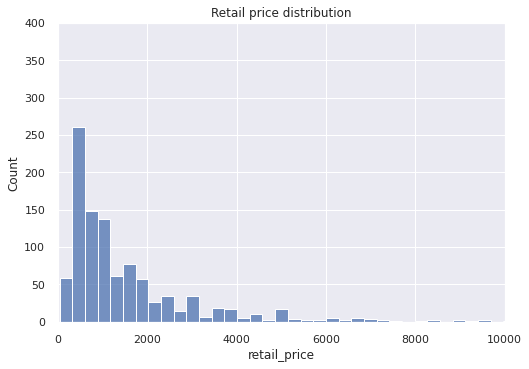

In [129]:
plt.xlim((0, 10000))
plt.ylim((0, 400))
plt.title('Retail price distribution')
sns.histplot(items_df['retail_price'])

### 3 discounted_price

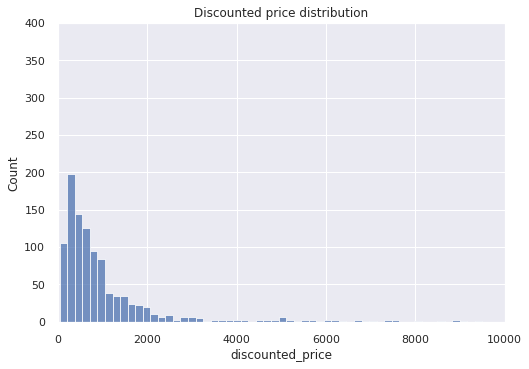

In [130]:
plt.xlim((0, 10000))
plt.ylim((0, 400))
plt.title('Discounted price distribution')
sns.histplot(items_df['discounted_price'])

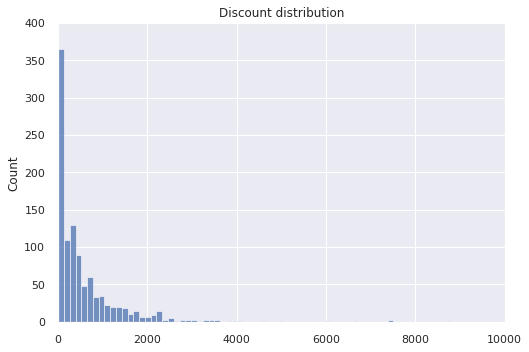

In [131]:
plt.xlim((0, 10000))
plt.ylim((0, 400))
plt.title('Discount distribution')
sns.histplot(items_df['retail_price']-items_df['discounted_price'])

In [132]:
items_df.head(3)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."


### 4 crawl_timestamp

In [133]:
data = pd.to_datetime(items_df['crawl_timestamp'])

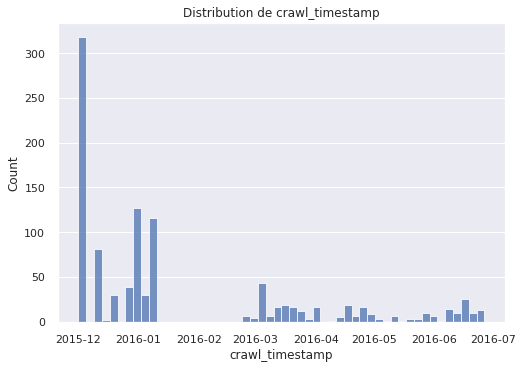

In [134]:
plt.title('Distribution de crawl_timestamp')
plt.grid(axis='x')
sns.histplot(data, bins=int(len(data)/20))

(array([ 19.,   0.,   1.,   0.,  14.,   0.,  13.,   0.,   0.,  13.,   0.,
        156.,   0., 161.,   0.,  39.,   0.,   0.,  50.,   0.,  65.,   0.,
         32.,   0., 102.,   0.,   0., 161.,   0.,  49.,   0.,  27.,   0.,
          7.,   0.,   0.,  12.,   0.,  11.,   0.,  21.,   0.,  59.,   0.,
          0.,   6.,   0.,  10.,   0.,   8.,   0.,  14.]),
 array([ 0.        ,  0.44230769,  0.88461538,  1.32692308,  1.76923077,
         2.21153846,  2.65384615,  3.09615385,  3.53846154,  3.98076923,
         4.42307692,  4.86538462,  5.30769231,  5.75      ,  6.19230769,
         6.63461538,  7.07692308,  7.51923077,  7.96153846,  8.40384615,
         8.84615385,  9.28846154,  9.73076923, 10.17307692, 10.61538462,
        11.05769231, 11.5       , 11.94230769, 12.38461538, 12.82692308,
        13.26923077, 13.71153846, 14.15384615, 14.59615385, 15.03846154,
        15.48076923, 15.92307692, 16.36538462, 16.80769231, 17.25      ,
        17.69230769, 18.13461538, 18.57692308, 19.01923077, 19

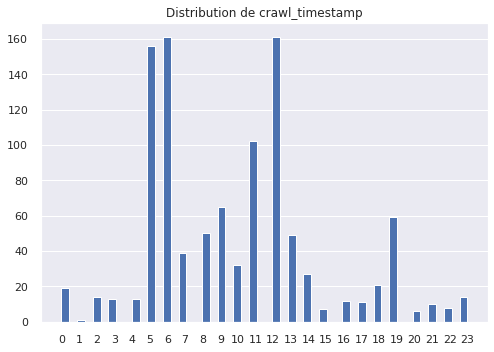

In [135]:
hours_serie = pd.to_datetime(items_df['crawl_timestamp']).dt.hour
plt.title('Distribution de crawl_timestamp')
plt.xticks(range(0, 24))
plt.grid(axis='x')
plt.hist(hours_serie,
         bins=int(len(data)/20))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 31 artists>

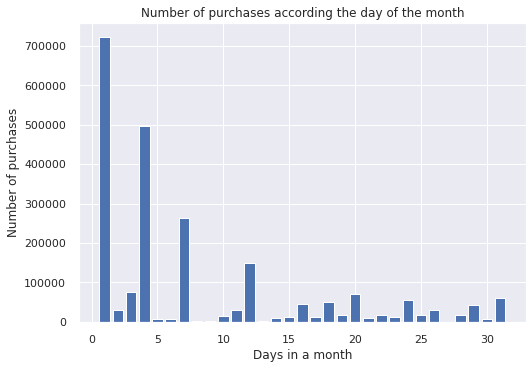

In [136]:
temp_df = items_df[['crawl_timestamp', 'retail_price']]
temp_df['crawl_timestamp'] = pd.to_datetime(temp_df['crawl_timestamp']).dt.day
temp_df = temp_df.groupby(by='crawl_timestamp', axis=0).sum().reset_index()
plt.title('Number of purchases according the day of the month')
plt.xlabel('Days in a month')
plt.ylabel('Number of purchases')
plt.bar(temp_df['crawl_timestamp'],
        temp_df['retail_price'])

### 5 product_url

In [137]:
items_df['product_url'][0]

'http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z'

In [138]:
items_df.drop('product_url', axis=1, inplace=True)

### 6 product_name

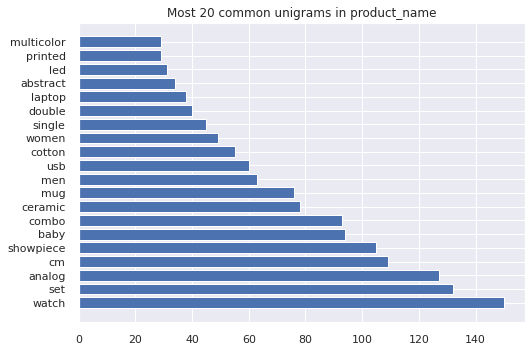

In [139]:
# Analysis of 1-gram words
column_most_common_words(items_df, 'product_name')

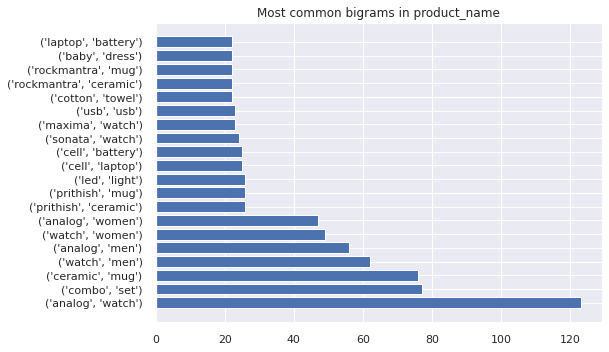

In [140]:
# Analysis of 2-gram words
def two_gram_words_pareto(df, column, threshold):
    sw = set()
    sw.update('stopwords')
    sw.update(tuple(nltk.corpus.stopwords.words('english')))
    # Clean data
    two_gram_words = []
    for product_name in df[column]:
        words = product_name.split(' ')
        words = [word.lower() for word in words
                 if len(word)>2
                 and word.lower() not in sw
                 and word.isalpha() == True]
        for combination in itertools.combinations(words, 2):
            two_gram_words.append(combination)
    words_counter = Counter(two_gram_words).most_common(threshold)
    words_df = pd.DataFrame(data=[words[1] for words in words_counter],
                           index=[words[0] for words in words_counter]).T
    my_keys = [str(column) for column in words_df.columns]
    my_values = list(words_df.iloc[0])
    # Plot
    plt.title('Most common bigrams in product_name')
    plt.barh(my_keys,
             my_values)

two_gram_words_pareto(items_df, 'product_name', 20)

### 7 product_category_tree

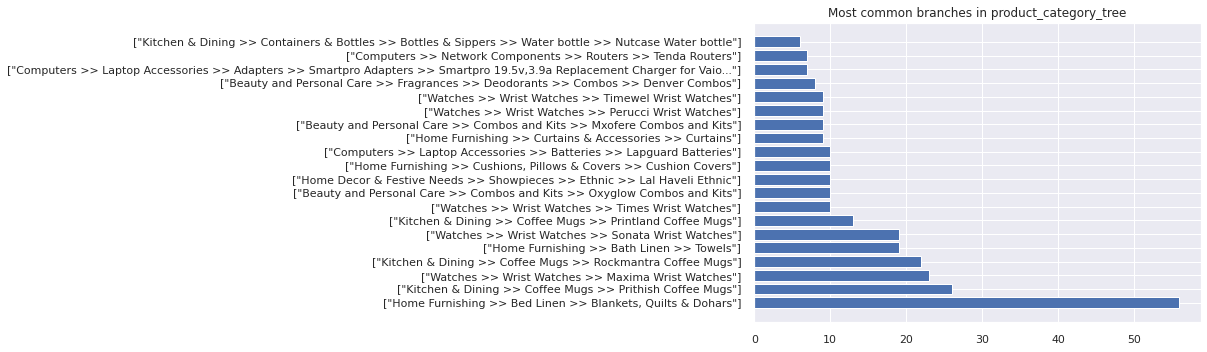

In [141]:
def main_product_categories_df(df, column, threshold):
    product_counter = Counter(df[column])
    product_df = pd.DataFrame({'word':dict(product_counter).keys(),
                               'count':dict(product_counter).values()})
    product_df.sort_values(by='count', inplace=True, ascending=False)
    plt.title('Most common branches in {}'.format(column))
    plt.barh(product_df['word'][:threshold],
             product_df['count'][:threshold])


main_product_categories_df(items_df, 'product_category_tree', 20)

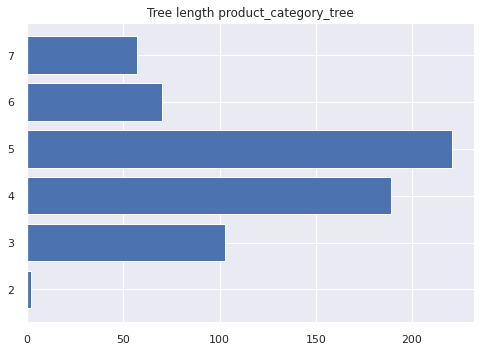

In [142]:
def tree_depths(df, column, threshold, separator):
    product_counter = Counter(df[column])
    product_df = pd.DataFrame({'word': dict(product_counter).keys(),
                               'count': dict(product_counter).values()})
    tree_length = [len(element.split(separator)) for element in product_df['word']]
    tree_length_counter = Counter(tree_length)
    categories_df = pd.DataFrame({'word':dict(tree_length_counter).keys(),
                                 'count':dict(tree_length_counter).values()})
    categories_df.sort_values(by='count', inplace=True, ascending=False)
    plt.title('Tree length {}'.format(column))
    plt.barh(categories_df['word'][:threshold],
             categories_df['count'][:threshold])


tree_depths(items_df, 'product_category_tree', 20, '>>')

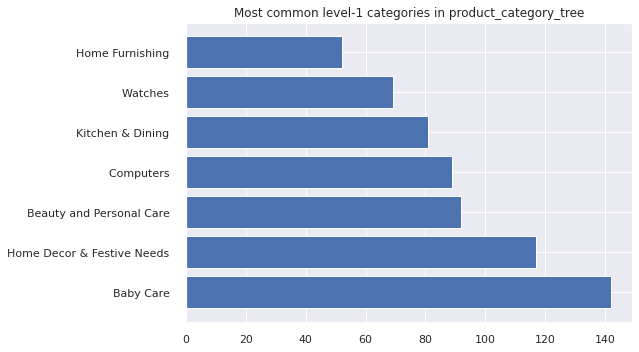

In [143]:
# Most common categories of 1st- and 2nd-level
def most_common_categories(df, column, threshold, separator, level):
    product_counter = Counter(df[column])
    product_df = pd.DataFrame({'word': dict(product_counter).keys(),
                               'count': dict(product_counter).values()})
    main_categories = [element.split(separator)[level-1] for element in product_df['word']]
    main_categories = [element[2:] for element in main_categories]
    categories_counter = Counter(main_categories)
    cat_names_df = pd.DataFrame({'category':dict(categories_counter).keys(),
                                 'count':dict(categories_counter).values()})
    cat_names_df.sort_values(by='count', inplace=True, ascending=False)
    plt.title('Most common level-{} categories in {}'.format(level, column))
    plt.barh(cat_names_df['category'],
             cat_names_df['count'])


most_common_categories(items_df, 'product_category_tree', 20, '>>', 1)

In [144]:
def extract_main_categories(df, column, separator):
    items_df['cat_tree_1st'] = [element.split(separator)[0][2:-1] for element in df[column]]
    items_df['cat_tree_2nd'] = [element.split(separator)[1][1:-1] for element in df[column]]
    return items_df.drop('product_category_tree', axis=1)

items_df = extract_main_categories(items_df, 'product_category_tree', '>>')

items_df.head(3)

,uniq_id,crawl_timestamp,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_tree_1st,cat_tree_2nd
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,Elegance Polyester Multicolor Abstract Eyelet ...,CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,Sathiyas Cotton Bath Towel,BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,Eurospa Cotton Terry Face Towel Set,BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,Baby Bath & Skin


### 8 is_FK_Advantage_product

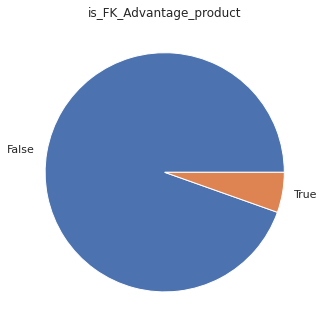

In [145]:
def plot_fk_davantage_product(df, column, threshold):
    fk_counter = Counter(df[column])
    product_df = pd.DataFrame({'word':dict(fk_counter).keys(),
                               'count':dict(fk_counter).values()})
    product_df.sort_values(by='count', inplace=True, ascending=False)
    plt.title(column)
    plt.pie(product_df['count'][:threshold],
            labels=product_df['word'][:threshold])


plot_fk_davantage_product(items_df, 'is_FK_Advantage_product', 20)

In [146]:
items_df.rename(columns={'is_FK_Advantage_product':'fk_adv_prod'}, inplace=True)
items_df['fk_adv_prod'].replace({False:0, True:1}, inplace=True)

### 9 description

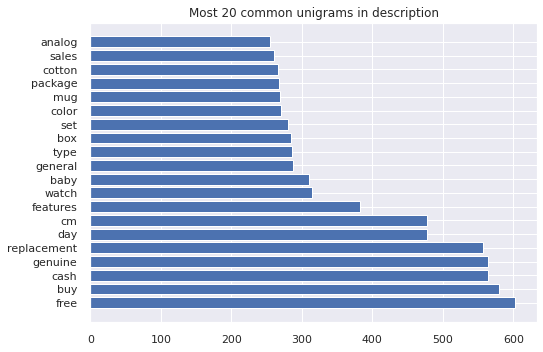

In [147]:
column_most_common_words(items_df, 'description')

### 10 product_rating

<BarContainer object of 20 artists>

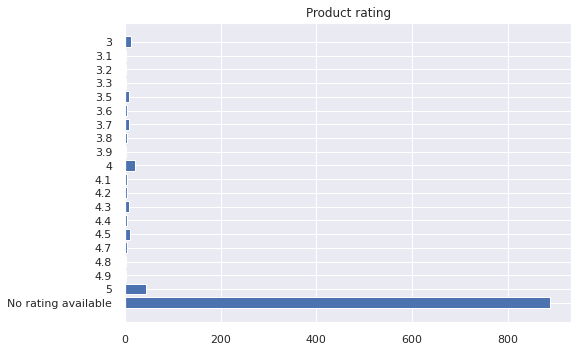

In [148]:
rating_counter = Counter(items_df['product_rating'])
ratings_df = pd.DataFrame({'rating':dict(rating_counter).keys(),
                           'count':dict(rating_counter).values()})
ratings_df.sort_values(by='rating', inplace=True, ascending=False)
plt.title('Product rating')
plt.barh(ratings_df['rating'][:20],
         ratings_df['count'][:20])

### 11 overall_rating

<BarContainer object of 20 artists>

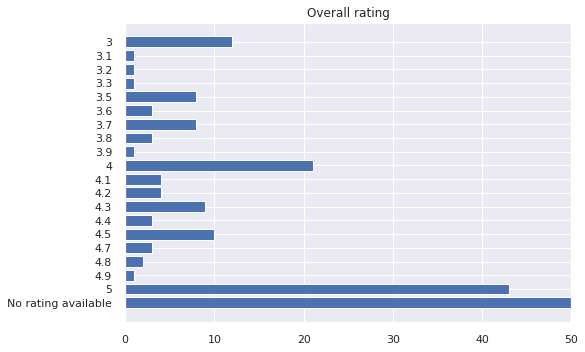

In [149]:
my_counter = Counter(items_df['overall_rating'])
product_ratings_df = pd.DataFrame({'rating':dict(my_counter).keys(),
                                   'count':dict(my_counter).values()})
product_ratings_df.sort_values(by='rating', inplace=True, ascending=False)
plt.xlim((0, 50))
plt.title('Overall rating')
plt.barh(product_ratings_df['rating'][:20],
         product_ratings_df['count'][:20])

### 12 brand

<BarContainer object of 20 artists>

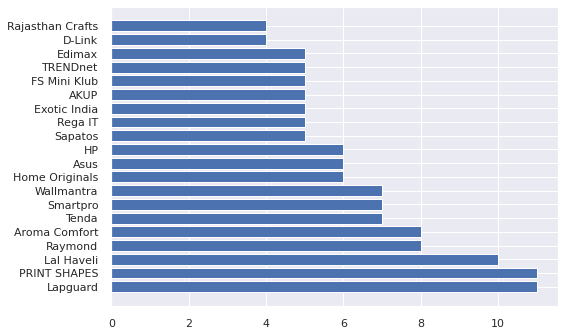

In [150]:
brands = []
for brand in items_df['brand']:
    brands.append(brand)
brand_counter = Counter(brands)
brands_df = pd.DataFrame({'word':dict(brand_counter).keys(),
                          'count':dict(brand_counter).values()})
brands_df.sort_values(by='count', inplace=True, ascending=False)
brands_df.dropna(inplace=True)
plt.barh(brands_df['word'][:20],
         brands_df['count'][:20])

In [151]:
#Pareto(items_df, 'brand')

In [152]:
print('Proportion of the most common brand in the whole original dataframe : \n{}%'.format(
    100*round(brands_df['count'][0]/items_df.shape[0],3)))

Proportion of the most common brand in the whole original dataframe : 
0.1%


In [153]:
# Check if some brands are not written several ways
brands_df['word'][:50]

215                Lapguard
479            PRINT SHAPES
80               Lal Haveli
334                 Raymond
481           Aroma Comfort
160                   Tenda
178                Smartpro
290              Wallmantra
297          Home Originals
158                    Asus
199                      HP
295                 Sapatos
219                 Rega IT
47             Exotic India
15                     AKUP
60             FS Mini Klub
162                TRENDnet
163                  Edimax
16                   D-Link
319        Rajasthan Crafts
270    The Intellect Bazaar
325               Offspring
214                 Cotonex
168                 Netgear
167                 TP-LINK
318             eCraftIndia
314             AntiqueShop
74          S C Handicrafts
53                     Rama
75                Tatvaarts
205            Fs Mini Klub
166                   Zyxel
433          FURNISHINGLAND
100               Metallino
413              Valtellina
409               Di

In [154]:
# The feature brand is too diverse. It does not provide much information,
# and is a source of noise. It looks better to reject it.
items_df.drop('brand', axis=1, inplace=True)

### 13 image

In [155]:
# Check if uniq_id allways corresponds to image
temp_df = items_df[['uniq_id', 'image']]
temp_df['image'] = [image_name[:-4] for image_name in temp_df['image']]
any(temp_df['uniq_id'] != temp_df['image'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


False

Les deux colonnes sont bien identiques. On peut en supprimer une sans perdre d'information.

In [156]:
items_df.drop('image', axis=1, inplace=True)

### 14 product_specifications

In [157]:
for specification in items_df['product_specifications'][:5]:
    print(specification)

{"product_specification"=>[{"key"=>"Brand", "value"=>"Elegance"}, {"key"=>"Designed For", "value"=>"Door"}, {"key"=>"Type", "value"=>"Eyelet"}, {"key"=>"Model Name", "value"=>"Abstract Polyester Door Curtain Set Of 2"}, {"key"=>"Model ID", "value"=>"Duster25"}, {"key"=>"Color", "value"=>"Multicolor"}, {"key"=>"Length", "value"=>"213 cm"}, {"key"=>"Number of Contents in Sales Package", "value"=>"Pack of 2"}, {"key"=>"Sales Package", "value"=>"2 Curtains"}, {"key"=>"Material", "value"=>"Polyester"}]}
{"product_specification"=>[{"key"=>"Machine Washable", "value"=>"Yes"}, {"key"=>"Material", "value"=>"Cotton"}, {"key"=>"Design", "value"=>"Self Design"}, {"key"=>"Brand", "value"=>"Sathiyas"}, {"key"=>"Type", "value"=>"Bath Towel"}, {"key"=>"GSM", "value"=>"500"}, {"key"=>"Model Name", "value"=>"Sathiyas cotton bath towel"}, {"key"=>"Ideal For", "value"=>"Men, Women, Boys, Girls"}, {"key"=>"Model ID", "value"=>"asvtwl322"}, {"key"=>"Color", "value"=>"Red, Yellow, Blue"}, {"key"=>"Size", "va

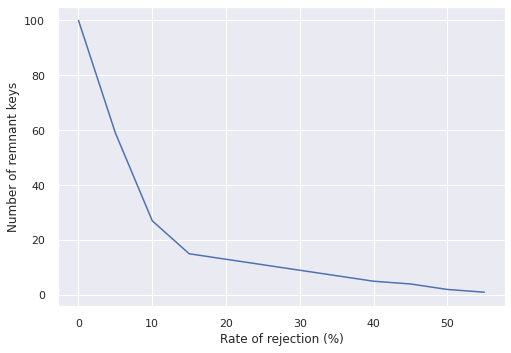

In [158]:
def dicts_from_raw_feature(df, column):
    super_spec_dict = {}
    leading_string = '{"'+column + '"=>[{"'
    for i, specification in enumerate(df[column].dropna()):
        if len(specification) > len(leading_string):
            spec_list = []
            for subelement in specification[27:].split('{'):
                spec_list.append(subelement[:-3])
            spec_list = spec_list[1:]
            spec_dict = {}
            for j in range(len(spec_list)):
                decomposition = spec_list[j].split("\"")
                # Spec name
                spec_dict[decomposition[3]] = decomposition[-2]
            super_spec_dict[i] = spec_dict
    return super_spec_dict


def keys_from_dict_of_dicts(dict_1):
    temp_list = []
    for element in dict_1.values():
        temp_list.append([key for key in element.keys()])
    keys_list = []
    for sub_list in temp_list:
        for key in sub_list:
            keys_list.append(key)
    return keys_list


def get_most_common_keys(df, keys_list, rate):
    temp_list = []
    df_size = df.shape[0]
    for key, count in Counter(keys_list).most_common(100):
        if count > df_size*rate:
            temp_list.append((key, count))
    selected_keys = [element[0] for element in temp_list]
    return selected_keys


def get_dict_from_element(element, separator):
    try:
        items = element.split(separator)
        element_dict = {}
        for i, item in enumerate(items):
            if item == 'key':
                key = items[i+2]
                value = items[i+6]
                element_dict[key] = value
        return element_dict
    except:
        return np.nan


def get_filtered_dict(input_dict, keys_list):
    new_dict = {}
    for key, value in input_dict.items():
        if key in keys_list:
            new_dict[key] = value
    return new_dict


# Study of the best rate
def plot_keys_functionof_rate(keys_list, df):
    rates_dict = {}
    rates_list = range(0, 60, 5)
    for rate in rates_list:
        temp_list = []
        for key, count in Counter(keys_list).most_common(100):
            if count > df.shape[0]*rate/100:
                temp_list.append((key, count))
        rates_dict[rate] = len(temp_list)
    plt.xlabel('Rate of rejection (%)')
    plt.ylabel('Number of remnant keys')
    plt.plot(list(rates_dict.keys()),
                list(rates_dict.values()))
    

all_dicts = dicts_from_raw_feature(items_df,'product_specifications')
keys_list = keys_from_dict_of_dicts(all_dicts)
plot_keys_functionof_rate(keys_list, items_df)

In [159]:
def clean_product_specification(df, rate, column, separator):
    # get the most common keys
    all_dicts = dicts_from_raw_feature(df, column)
    all_keys= keys_from_dict_of_dicts(all_dicts)
    most_common_keys = get_most_common_keys(items_df, all_keys, rate)
    # get the corresponding dicts
    df[column].dropna(inplace=True)
    new_feature = []
    for element in df[column]:
        raw_dict = get_dict_from_element(element, separator)
        if isinstance(raw_dict, dict):
            filtered_dict = get_filtered_dict(raw_dict, most_common_keys)
        else:
            filtered_dict = np.nan
        new_feature.append(filtered_dict)
    df.drop(column, axis=1, inplace=True)
    df['product_specifications_filtered'] = new_feature
    return df


items_df = clean_product_specification(items_df, 0.05, 'product_specifications', '\"')

### 15 pid

In [160]:
temp_df = items_df[['pid','product_name', 'product_specifications_filtered']]
temp_df.sort_values(by='pid').head(10)

,pid,product_name,product_specifications_filtered
83,ACBEGWQ2REAGC6JZ,HEAVENLY Dress Baby Boy's Combo,"{'Fabric': 'Cotton', 'Pattern': 'HALF SLEEVE',..."
865,ACBEHGARRYXEA4FA,kawal fashion Pyjama Baby Girl's Combo,"{'Ideal For': 'Baby Girl's', 'Style Code': 'mn..."
511,ACCDQDYBDNZRPMSW,Lapguard HP Pavilion dv5-1014tx 6 Cell Laptop ...,"{'In The Box': 'Laptop Battery', 'Brand': 'Lap..."
512,ACCDQDYBQ7YH7EF5,Lapguard HP Pavilion dv5-1020el 6 Cell Laptop ...,"{'In The Box': 'Laptop Battery', 'Brand': 'Lap..."
508,ACCDQDYBQZPEEXTY,Lapguard HP Pavilion dv5-1015nr 6 Cell Laptop ...,"{'In The Box': 'Laptop Battery', 'Brand': 'Lap..."
504,ACCDQDYBYVQZNHCH,Lapguard HP Pavilion dv5-1008ax 6 Cell Laptop ...,"{'In The Box': 'Laptop Battery', 'Brand': 'Lap..."
480,ACCDSY8EGJPW7RJB,HP Pavilion DV7t-6100 Series 6 Cell Laptop Bat...,"{'In The Box': 'Laptop Battery', 'Brand': 'HP'..."
490,ACCDSY8EHJF6GRMG,HP Compaq Presario CQ43 6 Cell Laptop Battery,"{'In The Box': 'Laptop Battery', 'Brand': 'HP'..."
481,ACCDSY8ESXF9AUHY,Lapguard HP Pavilion DV7-6000 Series 6 Cell La...,"{'Brand': 'Lapguard', 'In The Box': 'Laptop Ba..."
486,ACCDSY8EYXYYYYVK,HP Pavilion DV6-2070eo 6 Cell Laptop Battery,"{'Brand': 'HP', 'In The Box': 'Laptop Battery'..."


In [161]:
# The pid feature does not seem easy to analyse.
items_df.drop('pid', axis=1, inplace=True)

## B. Cleaning

### 1 Text features

In [162]:
def add_length_column(df, column):
    len_list = []
    for element in df[column]:
        len_list.append(len(element))
    df[column+'_length'] = len_list
    df.sort_values(by=column+'_length', ascending=False, inplace=True)
    return df


items_df = add_length_column(items_df, 'description')

In [163]:
def letters_only(cell):
    new_words = []
    cell = str(cell)
    words = cell.split(' ')
    for word in words:
        new_word = ''.join([i for i in word if i.isalpha()])
        new_words.append(new_word)
    return new_words


def get_stopwords_list(language):
    sw = set()
    sw.update('stopwords')
    sw.update(tuple(nltk.corpus.stopwords.words(language)))
    return list(sw)


def words_without_stopwords(sentence, sw_list):
    words_list = [word for word in sentence if word.lower() not in sw_list]
    return ' '.join(words_list)


def words_without_shortwords(sentence, min_length=3):
    temp_list = [word for word in sentence.split(' ') if len(word) >= min_length]
    return ' '.join(temp_list)


def stem_words(sentence, stemmer=EnglishStemmer()):
    words_list = []
    for word in sentence.split(' '):
        words_list.append(stemmer.stem(word))
    return ' '.join(words_list)


def clean_text_feature(df, column, output_check=False):
    new_feature = []
    stopwords_list = get_stopwords_list('english')
    for cell in df[column]:
        string = letters_only(cell)
        string = words_without_stopwords(string, stopwords_list)
        string = words_without_shortwords(string)
        string = stem_words(string)
        new_feature.append(string)
    new_df = df.copy()
    new_df[column] = new_feature
    return new_df


items_df = clean_text_feature(items_df, 'description')

In [164]:
def unique_keys_from_feature_of_dicts(df, column):
    keys = []
    for cell_dict in df[column]:
        if cell_dict is not np.nan:
            for key, value in cell_dict.items():
                keys.append(key)
    keys = pd.Series(keys).unique()
    return list(keys)


def df_with_columns_from_dicts(df, column, keys):
    new_df = df.copy()
    for key in keys:
        key_column = []
        for cell_dict in df[column]:
            if cell_dict is not np.nan:
                if key in cell_dict.keys():
                    key_column.append(cell_dict[key])
                else:
                    key_column.append(0)
            else:
                key_column.append(0)
        new_df['spec_'+key.lower()] = key_column
    return new_df


unique_keys = unique_keys_from_feature_of_dicts(items_df, 'product_specifications_filtered')
items_df = df_with_columns_from_dicts(items_df, 'product_specifications_filtered', unique_keys)

In [165]:
items_df.head(3)

,uniq_id,crawl_timestamp,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,cat_tree_1st,cat_tree_2nd,product_specifications_filtered,description_length,spec_brand,spec_suitable for,spec_model number,spec_covered in warranty,spec_warranty summary,spec_not covered in warranty,spec_weight,spec_height,spec_width,spec_depth,spec_type,spec_model name,spec_material,spec_style code,spec_color,spec_machine washable,spec_ideal for,spec_model id,spec_design,spec_size,spec_length,spec_number of contents in sales package,spec_sales package,spec_scratch resistant,spec_pack of,spec_warranty service type,spec_microwave safe,spec_in the box,spec_capacity,spec_water resistant,spec_freezer safe,spec_chronograph,spec_altimeter,spec_barometer,spec_calendar,spec_luminous,spec_mechanism,spec_occasion,spec_novelty feature,spec_dial shape,spec_strap color,spec_dial color,spec_strap material,spec_diameter,spec_pattern,spec_fabric,spec_mug capacity,spec_power source,spec_date display,spec_alarm clock,spec_compass,spec_series,spec_strap type,spec_case / bezel material,spec_water resistance depth,spec_clasp type,spec_model,spec_number of contents in set,spec_combo set content
437,b6c339777814451815fe7950fd4c8536,2016-06-16 08:51:06 +0000,HomeEdge Solid Wood King Bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,No rating available,No rating available,Beauty and Personal Care,Health Care,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,HomeEdge,"Bedroom, Kids Room",HE_BED_King_04,Limited to Manufacturing Defects Only,1 Year Company Domestic Warranty,Normal Wear and Tear is not a part of the warr...,80 kg,760 mm,1900 mm,2060 mm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639,aeb421e416716d5f037d50e8c3b14cd7,2016-06-22 20:52:57 +0000,Sunlast 16 inch Laptop Backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,No rating available,No rating available,Computers,Laptop Accessories,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,Sunlast,0,0,0,0,0,820 g,0,0,0,Laptop Backpack,L003 Yellow solar mobile charger,Nylon,L003 Yellow,Yellow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
715,d68b774e9529a4b94a5c6c8943a1b8b3,2016-01-01 19:37:22 +0000,Pioneer Pragati Floral Single Duvet Orange,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,No rating available,No rating available,Home Furnishing,Bed Linen,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,Pioneer Pragati,Single Bed,0,0,0,0,650 g,0,59 inch / 152 cm,0,Duvet,Floral Design With Gold Print,0,0,Orange,No,Boys and Girls,Floral Design With Gold Print,Gold Print Floral Design Duvet,Single,89 inch / 228 cm,1,1 Duvet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [166]:
def df_with_cleaned_weight_feature(df, column):
    weights = []
    for weight in df[column]:
        try:
            weights.append(float(weight)) # NaN included
        except ValueError:
            if 'g' in weight.lower():
                weights.append(float(weight.split(' ')[0]))
            elif 'kg' in weight.lower():
                weights.append(float(weight.split(' ')[0])*100)
            elif 'cm' in weight.lower():
                weights.append(np.nan)
            else:
                print(weight)
    df[column] = weights
    return df

df_with_cleaned_weight_feature(items_df, 'spec_weight').head(3)

,uniq_id,crawl_timestamp,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,cat_tree_1st,cat_tree_2nd,product_specifications_filtered,description_length,spec_brand,spec_suitable for,spec_model number,spec_covered in warranty,spec_warranty summary,spec_not covered in warranty,spec_weight,spec_height,spec_width,spec_depth,spec_type,spec_model name,spec_material,spec_style code,spec_color,spec_machine washable,spec_ideal for,spec_model id,spec_design,spec_size,spec_length,spec_number of contents in sales package,spec_sales package,spec_scratch resistant,spec_pack of,spec_warranty service type,spec_microwave safe,spec_in the box,spec_capacity,spec_water resistant,spec_freezer safe,spec_chronograph,spec_altimeter,spec_barometer,spec_calendar,spec_luminous,spec_mechanism,spec_occasion,spec_novelty feature,spec_dial shape,spec_strap color,spec_dial color,spec_strap material,spec_diameter,spec_pattern,spec_fabric,spec_mug capacity,spec_power source,spec_date display,spec_alarm clock,spec_compass,spec_series,spec_strap type,spec_case / bezel material,spec_water resistance depth,spec_clasp type,spec_model,spec_number of contents in set,spec_combo set content
437,b6c339777814451815fe7950fd4c8536,2016-06-16 08:51:06 +0000,HomeEdge Solid Wood King Bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,No rating available,No rating available,Beauty and Personal Care,Health Care,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,HomeEdge,"Bedroom, Kids Room",HE_BED_King_04,Limited to Manufacturing Defects Only,1 Year Company Domestic Warranty,Normal Wear and Tear is not a part of the warr...,80.0,760 mm,1900 mm,2060 mm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639,aeb421e416716d5f037d50e8c3b14cd7,2016-06-22 20:52:57 +0000,Sunlast 16 inch Laptop Backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,No rating available,No rating available,Computers,Laptop Accessories,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,Sunlast,0,0,0,0,0,820.0,0,0,0,Laptop Backpack,L003 Yellow solar mobile charger,Nylon,L003 Yellow,Yellow,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
715,d68b774e9529a4b94a5c6c8943a1b8b3,2016-01-01 19:37:22 +0000,Pioneer Pragati Floral Single Duvet Orange,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,No rating available,No rating available,Home Furnishing,Bed Linen,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,Pioneer Pragati,Single Bed,0,0,0,0,650.0,0,59 inch / 152 cm,0,Duvet,Floral Design With Gold Print,0,0,Orange,No,Boys and Girls,Floral Design With Gold Print,Gold Print Floral Design Duvet,Single,89 inch / 228 cm,1,1 Duvet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [167]:
# Clean as well the spec_ features of items_df
spec_list = [column for column in items_df.columns if column[:5]=='spec_']
for column in spec_list:
    items_df = clean_text_feature(items_df, column)
    items_df[column] = items_df[column].astype(str)

# Other cleaning
items_df = clean_text_feature(items_df, 'product_name')
items_df = clean_text_feature(items_df, 'cat_tree_1st')
items_df = clean_text_feature(items_df, 'cat_tree_2nd')

In [168]:
items_df.head(3)

,uniq_id,crawl_timestamp,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,cat_tree_1st,cat_tree_2nd,product_specifications_filtered,description_length,spec_brand,spec_suitable for,spec_model number,spec_covered in warranty,spec_warranty summary,spec_not covered in warranty,spec_weight,spec_height,spec_width,spec_depth,spec_type,spec_model name,spec_material,spec_style code,spec_color,spec_machine washable,spec_ideal for,spec_model id,spec_design,spec_size,spec_length,spec_number of contents in sales package,spec_sales package,spec_scratch resistant,spec_pack of,spec_warranty service type,spec_microwave safe,spec_in the box,spec_capacity,spec_water resistant,spec_freezer safe,spec_chronograph,spec_altimeter,spec_barometer,spec_calendar,spec_luminous,spec_mechanism,spec_occasion,spec_novelty feature,spec_dial shape,spec_strap color,spec_dial color,spec_strap material,spec_diameter,spec_pattern,spec_fabric,spec_mug capacity,spec_power source,spec_date display,spec_alarm clock,spec_compass,spec_series,spec_strap type,spec_case / bezel material,spec_water resistance depth,spec_clasp type,spec_model,spec_number of contents in set,spec_combo set content
437,b6c339777814451815fe7950fd4c8536,2016-06-16 08:51:06 +0000,homeedg solid wood king bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,No rating available,No rating available,beauti person care,health care,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,homeedg,bedroom kid room,hebedk,limit manufactur defect,year compani domest warranti,normal wear tear part warranti,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
639,aeb421e416716d5f037d50e8c3b14cd7,2016-06-22 20:52:57 +0000,sunlast inch laptop backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,No rating available,No rating available,comput,laptop accessori,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,sunlast,,,,,,,,,,laptop backpack,yellow solar mobil charger,nylon,yellow,yellow,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
715,d68b774e9529a4b94a5c6c8943a1b8b3,2016-01-01 19:37:22 +0000,pioneer pragati floral singl duvet orang,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,No rating available,No rating available,home furnish,bed linen,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,pioneer pragati,singl bed,,,,,,,inch,,duvet,floral design gold print,,,orang,,boy girl,floral design gold print,gold print floral design duvet,singl,inch,,duvet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


### 2 timestamp

In [169]:
# Replace each date by the difference (in days) with the latest date
def replace_dates_with_differences(df, column):
    df[column] = pd.to_datetime(df[column])
    most_recent_date = max(df[column])
    df['oldness'] = df[column] - most_recent_date
    df['oldness'] = [element.days for element in df['oldness']]
    df.drop(column, axis=1, inplace=True)
    return df


items_df = replace_dates_with_differences(items_df, 'crawl_timestamp')

### 3 ratings

In [170]:
def fill_nan_for_ratings(df, column, nan_string):
    non_nans = df[column].apply(lambda x: isinstance(x, float))
    df[column].replace(nan_string, non_nans.mean(), inplace=True)
    return df


items_df = fill_nan_for_ratings(items_df, 'product_rating', 'No rating available')
items_df = fill_nan_for_ratings(items_df, 'overall_rating', 'No rating available')

### 4 Outliers

In [171]:
items_df.head(3)

,uniq_id,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,cat_tree_1st,cat_tree_2nd,product_specifications_filtered,description_length,spec_brand,spec_suitable for,spec_model number,spec_covered in warranty,spec_warranty summary,spec_not covered in warranty,spec_weight,spec_height,spec_width,spec_depth,spec_type,spec_model name,spec_material,spec_style code,spec_color,spec_machine washable,spec_ideal for,spec_model id,spec_design,spec_size,spec_length,spec_number of contents in sales package,spec_sales package,spec_scratch resistant,spec_pack of,spec_warranty service type,spec_microwave safe,spec_in the box,spec_capacity,spec_water resistant,spec_freezer safe,spec_chronograph,spec_altimeter,spec_barometer,spec_calendar,spec_luminous,spec_mechanism,spec_occasion,spec_novelty feature,spec_dial shape,spec_strap color,spec_dial color,spec_strap material,spec_diameter,spec_pattern,spec_fabric,spec_mug capacity,spec_power source,spec_date display,spec_alarm clock,spec_compass,spec_series,spec_strap type,spec_case / bezel material,spec_water resistance depth,spec_clasp type,spec_model,spec_number of contents in set,spec_combo set content,oldness
437,b6c339777814451815fe7950fd4c8536,homeedg solid wood king bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,0,0,beauti person care,health care,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,homeedg,bedroom kid room,hebedk,limit manufactur defect,year compani domest warranti,normal wear tear part warranti,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-11
639,aeb421e416716d5f037d50e8c3b14cd7,sunlast inch laptop backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,0,0,comput,laptop accessori,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,sunlast,,,,,,,,,,laptop backpack,yellow solar mobil charger,nylon,yellow,yellow,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-4
715,d68b774e9529a4b94a5c6c8943a1b8b3,pioneer pragati floral singl duvet orang,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,0,0,home furnish,bed linen,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,pioneer pragati,singl bed,,,,,,,inch,,duvet,floral design gold print,,,orang,,boy girl,floral design gold print,gold print floral design duvet,singl,inch,,duvet,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,-177


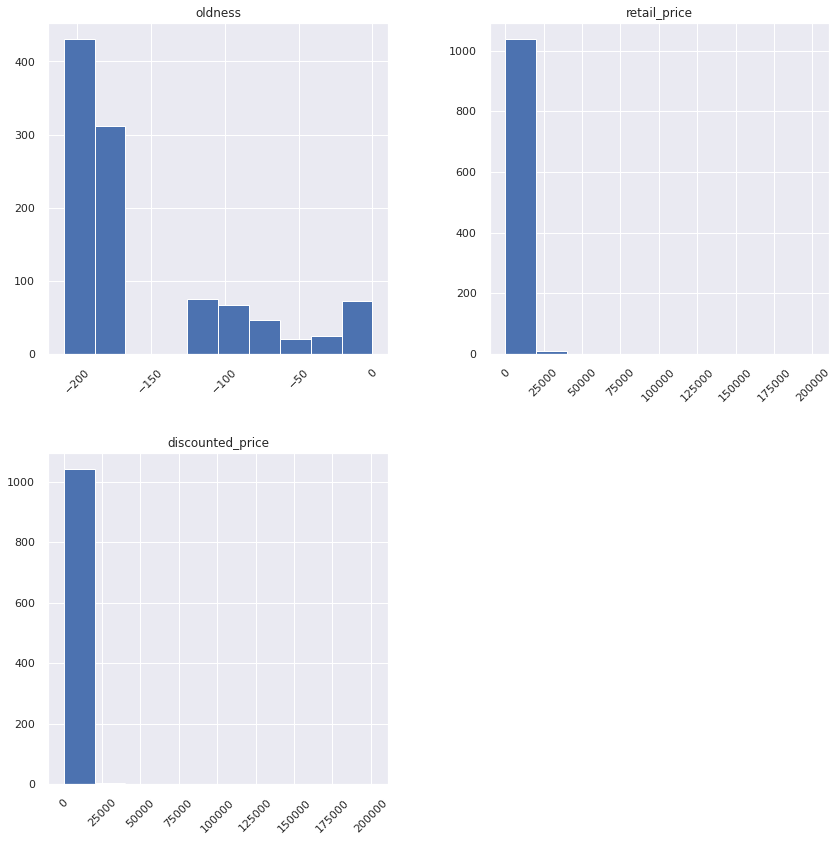

In [172]:
unencoded_col = ['oldness',
                 'retail_price',
                 'discounted_price',
                 'product_rating',
                 'overall_rating',
                 'spec_weight']
items_df[unencoded_col].hist(figsize=(14,14), xrot=45) 
plt.show()

In [173]:
def remove_upper_outliers(df, column, max_value, quantile_sup=0.95):
    if max_value is None:
        max_value = df[column].quantile(quantile_sup)
    df = df[df[column] < max_value]
    return df


def extreme_values(df, column, nb, extreme):
    '''Returns a 2-columns dataframe (uniq_id and the given feature), of the n-th
    highest (or lowest) values.'''
    if extreme == 'high':
        temp_df = df.sort_values(by=column, ascending=False)[:nb]
    elif extreme == 'low':
        temp_df = df.sort_values(by=column, ascending=True)[:nb]
    else:
        raise Exception
    return temp_df[['uniq_id', column]]

# retail_price
extreme_values(items_df, 'retail_price', nb=5, extreme='high')
# No outliers identified among the highest values
# No outliers identified among the 5 lowest values

# discounted_price
# No outliers identified among the 5 lowest values
# No outliers identified among the 5 highest values

,uniq_id,retail_price
11,08452abdadb3db1e686b94a9c52fc7b6,201000.0
9,710ed5f2393a4b9e8823aa0029f71f93,107750.0
604,85aec4bf3185da7ebcc45003429cbfe2,38890.0
605,bcb8e456728013a90ba66ab3b1b783ad,35390.0
318,fd2716d0e5dd7ffc367ca4dd9f97aaa0,29990.0


## C. Text data

### 1 Classical encoding

In [174]:
def classical_encoding(df, column, prefixe):
    '''Encode the given feature of the given dataframe. Returns the transformed dataframe.'''
    enc = OneHotEncoder()
    column_array = np.array(df[column]).reshape(-1, 1)
    encoded_array = enc.fit_transform(column_array).toarray()
    columns = [prefixe + element.replace(' ', '_') for element in list(items_df[column].unique())]
    encoded_df = pd.DataFrame(data=encoded_array,
                              columns=columns,
                              index=df.index)
    df = pd.merge(df, encoded_df,
                           left_index=True, right_index=True)
    df.drop(column, axis=1, inplace=True)
    return df

In [175]:
items_df = classical_encoding(items_df, 'cat_tree_1st', 'cat1_')
items_df = classical_encoding(items_df, 'cat_tree_2nd', 'cat2_')

In [176]:
items_df.head(3)

,uniq_id,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,product_specifications_filtered,description_length,spec_brand,spec_suitable for,spec_model number,spec_covered in warranty,spec_warranty summary,spec_not covered in warranty,spec_weight,spec_height,spec_width,spec_depth,spec_type,spec_model name,spec_material,spec_style code,spec_color,spec_machine washable,spec_ideal for,spec_model id,spec_design,spec_size,spec_length,spec_number of contents in sales package,spec_sales package,spec_scratch resistant,spec_pack of,spec_warranty service type,spec_microwave safe,spec_in the box,spec_capacity,spec_water resistant,...,cat2_contain_bottl,cat2_diaper_potti_train,cat2_comput_peripher,cat2_tablet_accessori,cat2_bath_linen,cat2_live_room_furnish,cat2_candl_fragranc,cat2_bar_glasswar,cat2_kitchen_dine_linen,cat2_babi_bath_skin,cat2_hair_care,cat2_decor_light_lamp,cat2_religion_devot,cat2_makeup,cat2_fragranc,cat2_cushion_pillow_cover,cat2_live,cat2_floor_cover,cat2_storag,cat2_network_compon,cat2_babi_groom,cat2_comput_compon,cat2_stroller_activ_gear,cat2_bodi_skin_care,cat2_light,cat2_tidi_home_furnish,cat2_dinnerwar_crockeri,cat2_jmd_home_furnish,cat2_clock,cat2_feed_nurs,cat2_kripa_home_furnish,cat2_beauti_accessori,cat2_women_hygien,cat2_laptop,cat2_men_groom,cat2_furnitur_furnish,cat2_eye_care,cat2_housekeep_laundri,cat2_pressur_cooker_pan,cat2_true_home_decor_festiv_need
437,b6c339777814451815fe7950fd4c8536,homeedg solid wood king bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,0,0,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,homeedg,bedroom kid room,hebedk,limit manufactur defect,year compani domest warranti,normal wear tear part warranti,,,,,,,,,,,,,,,,,,,,,,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,aeb421e416716d5f037d50e8c3b14cd7,sunlast inch laptop backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,0,0,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,sunlast,,,,,,,,,,laptop backpack,yellow solar mobil charger,nylon,yellow,yellow,,,,,,,,,,,,,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
715,d68b774e9529a4b94a5c6c8943a1b8b3,pioneer pragati floral singl duvet orang,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,0,0,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,pioneer pragati,singl bed,,,,,,,inch,,duvet,floral design gold print,,,orang,,boy girl,floral design gold print,gold print floral design duvet,singl,inch,,duvet,,,,,,,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2 Specific encoding

In [177]:
def words_in_feature(df, column):
    words_list = []
    for element in df[column]:
        # Several words
        if len(element.split(' ')) > 1:
            for word in element.split(' '):
                words_list.append(word)
        # Only one word
        else:
            words_list.append(element)
    return words_list


def words_counter_in_feature(df, column) -> pd.DataFrame:
    words_list = words_in_feature(df, column)
    words_counter = Counter(words_list)
    first_ones = int(len(words_counter)/10)+1
    words_df = pd.DataFrame()
    words_df['keys'] = [element[0] for element in words_counter.most_common(first_ones)]
    words_df['values'] = [element[1] for element in words_counter.most_common(first_ones)]
    return words_df


def filter_spec_feat(df, column, ratio=0.01):
    '''Given a text feature, returns the list of the most common words, whose
    ratio lies above the given ratio.'''
    words_df = words_counter_in_feature(df, column)
    #
    words_df = words_df[words_df['keys']!='nan']
    words_df = words_df[words_df['keys']!='']
    words_df = words_df[words_df['values']>ratio*len(df)]
    # gather most common words
    new_list = []
    for i, element in enumerate(df[column]):
        indic = set(df['spec_type'].iloc[i].split(' ')).intersection(set(words_df['keys']))
        if len(indic) > 0:
            new_list.append(' '.join(list(indic)))
        else:
            new_list.append('')
    df[column] = new_list
    return df


def specific_encoding(df, column):
    '''Encode the given text feature of the given dataframe.
    Consider all different words in a cell (which is not done by OneHotEncoder)
    Returns the modified dataframe.'''
    for i, list_ in enumerate(df[column]):
        for word in list_.split(' '):
            word_col = str(column + '_' + word)
            if word_col in df.columns:
                df[column + '_' + word].iloc[i] = 1
            else:
                df[column + '_' + word] = [0] * df.shape[0]
                df[column + '_' + word].iloc[i] = 1
    df.drop(column, axis=1, inplace=True)
    return df


items_df = filter_spec_feat(items_df, 'spec_type')

for spec_feature in spec_list:
    items_df = specific_encoding(items_df, spec_feature)

# NaN
nan_col = [column for column in list(items_df.columns) if column [-4:]=='_nan']
for column in nan_col:
    items_df.drop(column, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [178]:
items_df.head(3)

,uniq_id,product_name,retail_price,discounted_price,fk_adv_prod,description,product_rating,overall_rating,product_specifications_filtered,description_length,oldness,cat1_beauti_person_care,cat1_comput,cat1_home_furnish,cat1_home_decor_festiv_need,cat1_babi_care,cat1_kitchen_dine,cat1_watch,cat2_health_care,cat2_laptop_accessori,cat2_bed_linen,cat2_wall_decor_clock,cat2_babi_kid_gift,cat2_tablewar_cutleri,cat2_kitchen_tool,cat2_showpiec,cat2_garden_leisur,cat2_combo_kit,cat2_tabl_decor_handicraft,cat2_babi_bed,cat2_flower_plant_vase,cat2_consum_dispos,cat2_wrist_watch,cat2_softwar,cat2_cookwar,cat2_bath_spa,cat2_infant_wear,cat2_coffe_mug,cat2_curtain_accessori,cat2_contain_bottl,...,spec_combo set content_berlin,spec_combo set content_malibu,spec_combo set content_engag,spec_combo set content_blush,spec_combo set content_drizzl,spec_combo set content_charg,spec_combo set content_surg,spec_combo set content_teas,spec_combo set content_pride,spec_combo set content_sport,spec_combo set content_drift,spec_combo set content_wave,spec_combo set content_ladi,spec_combo set content_womenml,spec_combo set content_rio,spec_combo set content_hawaii,spec_combo set content_calib,spec_combo set content_brave,spec_combo set content_rush,spec_combo set content_jump,spec_combo set content_pack,spec_combo set content_cool,spec_combo set content_spring,spec_combo set content_forcegmfor,spec_combo set content_electr,spec_combo set content_spraygmfor,spec_combo set content_archis,spec_combo set content_privaci,spec_combo set content_blade,spec_combo set content_citi,spec_combo set content_gang,spec_combo set content_nike,spec_combo set content_gold,spec_combo set content_casual,spec_combo set content_fission,spec_combo set content_equiti,spec_combo set content_illus,spec_combo set content_musk,spec_combo set content_combo,spec_combo set content_sethypnotti
437,b6c339777814451815fe7950fd4c8536,homeedg solid wood king bed,25499.0,18799.0,0,key featur homeedg solid wood king bed king be...,0,0,"{'Brand': 'HomeEdge', 'Suitable For': 'Bedroom...",3490,-11,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639,aeb421e416716d5f037d50e8c3b14cd7,sunlast inch laptop backpack,2600.0,2348.0,0,key featur sunlast inch laptop backpack laptop...,0,0,"{'Brand': 'Sunlast', 'Type': 'Laptop Backpack'...",3447,-4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
715,d68b774e9529a4b94a5c6c8943a1b8b3,pioneer pragati floral singl duvet orang,1999.0,1099.0,0,pioneer pragati floral singl duvet orang duvet...,0,0,"{'Machine Washable': 'No', 'Brand': 'Pioneer P...",2594,-177,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [179]:
spec_columns = [column for column in list(items_df.columns) if column[:4]=='spec']
items_df[spec_columns].head(3)

,spec_brand_homeedg,spec_brand_sunlast,spec_brand_pioneer,spec_brand_pragati,spec_brand_wallskart,spec_brand_shopfloorxyz,spec_brand_oren,spec_brand_empow,spec_brand_talleng,spec_brand_smartpro,spec_brand_dungri,spec_brand_india,spec_brand_craft,spec_brand_checker,spec_brand_chef,spec_brand_servic,spec_brand_junction,spec_brand_clublaptop,spec_brand_rrsskid,spec_brand_,spec_brand_craftartz,spec_brand_bela,spec_brand_home,spec_brand_lapguard,spec_brand_miracl,spec_brand_retail,spec_brand_sparkl,spec_brand_reiki,spec_brand_crystal,spec_brand_product,spec_brand_caffein,spec_brand_prisha,spec_brand_wallmantra,spec_brand_eurekain,spec_brand_famous,spec_brand_pristin,spec_brand_aster,spec_brand_luxuri,spec_brand_tiedribbon,spec_brand_brandwagon,...,spec_combo set content_berlin,spec_combo set content_malibu,spec_combo set content_engag,spec_combo set content_blush,spec_combo set content_drizzl,spec_combo set content_charg,spec_combo set content_surg,spec_combo set content_teas,spec_combo set content_pride,spec_combo set content_sport,spec_combo set content_drift,spec_combo set content_wave,spec_combo set content_ladi,spec_combo set content_womenml,spec_combo set content_rio,spec_combo set content_hawaii,spec_combo set content_calib,spec_combo set content_brave,spec_combo set content_rush,spec_combo set content_jump,spec_combo set content_pack,spec_combo set content_cool,spec_combo set content_spring,spec_combo set content_forcegmfor,spec_combo set content_electr,spec_combo set content_spraygmfor,spec_combo set content_archis,spec_combo set content_privaci,spec_combo set content_blade,spec_combo set content_citi,spec_combo set content_gang,spec_combo set content_nike,spec_combo set content_gold,spec_combo set content_casual,spec_combo set content_fission,spec_combo set content_equiti,spec_combo set content_illus,spec_combo set content_musk,spec_combo set content_combo,spec_combo set content_sethypnotti
437,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
639,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
715,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 3 tf-idf weights

https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089

In [180]:
# Creation of stopwords set
sw = set()
sw.update('stopwords')
sw.update(tuple(nltk.corpus.stopwords.words('english')))

def add_tf_idf(df, column):
    '''Create new features based on tf-idf weights of the words
    contained in the given column.'''
    vectorizer = TfidfVectorizer(max_df=1.0, min_df=1,
                                 stop_words=list(sw), use_idf=True)
    string_df = df[column].apply(lambda x: str(x))
    #df[column] = pd.Series(list(df[column]), dtype=str)
    values = vectorizer.fit_transform(string_df).toarray()
    words_list = []
    prefix = column[:4]
    for key in vectorizer.vocabulary_.keys():
            words_list.append(prefix + '_' + key)
    words_df = pd.DataFrame(data=values, columns=words_list, index=df.index)
    df.drop(column, axis=1, inplace=True)
    df = pd.concat([df, words_df], axis=1)
    return df


# Compute the tf-idf weight for feature description
items_df = add_tf_idf(items_df, 'product_name')
items_df = add_tf_idf(items_df, 'description')

In [181]:
items_df.shape

(1050, 9709)

### 5 Latent Dirichlet Allocation

In [182]:
n_topics = 4

In [183]:
def LDA_that(data_, n_topics=n_topics, max_iter=10,
             learning_offset=50., max_features=1000, my_language='english'):
    '''Returns a grouping of words using LDA algorithm.'''
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=max_features, stop_words=my_language)
    tf = tf_vectorizer.fit_transform(data_)
    # 
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter, 
                                    learning_method='online', learning_offset=learning_offset,
                                    random_state=0)
    lda.fit(tf)
    return lda, tf_vectorizer

In [184]:
# Display the groups
def display_topics(model, columns, no_top_words=8):
    '''Returns a vizualisation of words groups'''
    topics_df = pd.DataFrame()
    for topic_idx, topic in enumerate(model.components_):
        temp_list = [columns[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics_df['topic_{}'.format(topic_idx)] = temp_list
    return topics_df

In [185]:
if False:
    lda, tf_vectorizer = LDA_that(data_=data, n_topics=n_topics,
                                max_iter=10, learning_offset=50.,
                                max_features=2000,)
    my_df = display_topics(lda, tf_vectorizer.get_feature_names(),
                           no_top_words=8)
    my_df.iloc[:, :4]

**Représentation**

In [186]:
if False:
    # Fitter sur les données
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=1000, stop_words='english')
    tf = tf_vectorizer.fit_transform(data)
    feature_names = np.array(tf_vectorizer.get_feature_names())
    # Créer le modèle LDA
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=10, 
                                    learning_method='online', learning_offset=50,
                                    random_state=0)
    document_topics = lda.fit_transform(tf)
    sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
    # Inspiré du livre "Le Machine Learning avec Python"
    fig, ax = plt.subplots(figsize=((10, 5)))
    topic_names = ['{:>2} '.format(i) + ' '.join(words) for i, words in enumerate(feature_names[sorting[:, :2]])]
    start = 0
    end = document_topics.shape[1]
    ax.barh(np.arange(document_topics.shape[1]),
            np.sum(document_topics, axis=0)[start:end])
    ax.set_yticks(np.arange(document_topics.shape[1]))
    ax.set_yticklabels(topic_names[start:end],
                    ha='left', va='top')
    ax.invert_yaxis()
    ax.set_xlim(0, max(np.sum(document_topics, axis=0))*1.1)
    yax = ax.get_yaxis()
    yax.set_tick_params(pad=130)
    plt.tight_layout()

In [187]:
if False:
    # Sum - invariant according the number of groups
    sum(np.sum(document_topics, axis=0)[start:end])
    # Mean
    stat.mean(np.sum(document_topics, axis=0)[start:end])
    # Standard deviation
    stat.stdev(np.sum(document_topics, axis=0)[start:end])

## D. Pictures data

### 1 Discovery

**Exploration**

In [188]:
items_df.sort_values(by='uniq_id', inplace=True)
items_df = items_df[items_df['uniq_id']!='5518124b75d6c6dfee4c2e4c0cfa716a']

In [189]:
def shades_hist(img_, adapt_scale=True):
    mat = np.array(img_)
    mat_flatten = mat.flatten()
    plt.xlim((0, 260))
    if adapt_scale:
        plt.ylim((0, mat_flatten.mean()*len(mat)))
    else:
        plt.ylim((0, 1000000))
    n, bins, patches = plt.hist(mat_flatten, bins=range(256))
    plt.show()

In [190]:
if False:
    widths_list = []
    heights_list = []
    means_list = []
    stddev_list = []
    unique_values_list = []
    length = len(items_df)
    for i, element in enumerate(items_df['uniq_id']):
        img = Image.open(PATH_PICTURE + element + '.jpg')

In [191]:
if False:
    plt.xlim((0, 260))
    plt.ylim((0, 100))
    plt.title('Shades of grey on the picture corpus (averages)')
    sns.histplot(means_list,
                 bins=52)

In [192]:
if False:
    plt.xlim((0, 260))
    #plt.ylim((0, 950))
    plt.title('Number of shades per image')
    sns.histplot(unique_values_list,
                 bins=104)

In [193]:
if False:
    sns.jointplot(widths_list,
                  heights_list)

In [194]:
if False:
    dimension_list = [w*h for w, h in zip(widths_list, heights_list)]
    sns.histplot(dimension_list)

In [195]:
if False:
    sns.jointplot(dimension_list,
                  means_list)

### 2 Equalization

In [196]:
img_id = '9438a0874e0486f46f3669cac6c2ac90'

In [197]:
def open_img(img_id):
    '''Open image of the given unique identificator.
    Return the equalized gray image.'''
    img = Image.open(PATH_PICTURE + img_id + '.jpg', mode='r')
    img = ImageOps.equalize(img)
    img = img.convert('LA')
    return img

In [198]:
def opencv_open_img(img_id):
    '''Open image of the given unique identificator.
    Return the equalized gray image.'''   
    img = cv2.imread(PATH_PICTURE + str(img_id) + '.jpg')
    img_arr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_arr = cv2.equalizeHist(img_arr)
    img = Image.fromarray(img_arr, 'L')
    return img

### 3 Filtering through average

In [199]:
if False:
    img_mean = img.filter(ImageFilter.BoxBlur(radius=2))
    shades_hist(img_mean)
    img_mean

### 4 Filtering through median

In [200]:
if False:
    img_median = img.filter(ImageFilter.MedianFilter(size=3))
    shades_hist(img_median)
    img_median

### 5 Gaussian filtering

In [201]:
def gaussian_filter(image):
    img_arr = np.asarray(image)
    nb_pixels = img_arr.shape[0] * img_arr.shape[1]
    radius = int(math.log(nb_pixels)/2.5)
    img_gauss = image.filter(ImageFilter.GaussianBlur(radius=radius))
    return img_gauss


def opencv_gaussian_filter(image):
    img_arr = np.asarray(image)
    nb_pixels = img_arr.shape[0] * img_arr.shape[1]
    temp_radius = 5
    img_gauss = cv2.GaussianBlur(img_arr, (temp_radius, temp_radius), cv2.BORDER_DEFAULT)
    return img_gauss


def diff_of_gaussians(my_image, radius_1, radius_2):
    img_1 = gaussian_filter(my_image, radius_1)
    img_2 = gaussian_filter(my_image, radius_2)
    array_1 = np.asarray(img_1)
    array_2 = np.asarray(img_2)
    temp_diff = Image.fromarray(array_2 - array_1)
    return temp_diff.convert('1')

### 6 Gradient visualisation

In [202]:
def plot_gradient(my_image):
    mat = np.array(my_image)[:, :, 0]
    plt.gray()
    plt.figure(figsize=(8, 8))
    edges = filters.sobel(mat)
    plt.imshow(edges)
    plt.title('Gradient', size=20)
    plt.show()

### 7 Canny filter

In [203]:
def canny_filter(image, sigma=3):
    if len(np.asarray(image).shape) == 3:
        mat = np.asarray(image)[:, :, 0]
    else:
        mat = np.array(image)
    edges = feature.canny(mat, sigma=sigma)
    img = Image.fromarray(edges)
    return img

In [204]:
def opencv_canny_filter(image, sigma=3):
    if len(np.asarray(image).shape) == 3:
        mat = np.array(image)[:, :, 0]
    else:
        mat = np.array(image)
    img = cv2.Canny(mat, threshold1=100, threshold2=200,
                    apertureSize=sigma, L2gradient = True)
    #img = Image.fromarray(img)
    return img

### 8 Harris-Stephens filter

In [205]:
if False:
    img = cv2.imread(PATH_PICTURE + img_id + '.jpg')
    gray = cv2.cvtColor(np.float32(img), cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray, 2, 3, 0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()] = [0, 0, 255]
    cv2_imshow(img)
    if cv2.waitKey(0) & 0xff == 27:
        cv2.destroyAllWindows()

### 9 SIFT

In [206]:
# Useful link : https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/

In [207]:
if False:
    # 1. Constructing a scale space
    img_width = img.size[0]
    img_height = img.size[1]
    # Octave 1 : 0.75 of the original
    img_oct_1 = img.resize((int(img_width*0.75),
                            int(img_height*0.75)))
    # Octave 2 : 0.50 of the original
    img_oct_2 = img.resize((int(img_width*0.50),
                            int(img_height*0.50)))
    # Octave 3 : 0.25 of the original
    img_oct_3 = img.resize((int(img_width*0.25),
                            int(img_height*0.25)))

In [208]:
if False:
    img_gauss_dict = {}
    array_gauss_dict = {}
    for i in [2, 5, 10, 20, 50]:
        img_gauss_dict[i] = img.filter(ImageFilter.GaussianBlur(radius=i))
        array_gauss_dict[i] = np.asarray(img_gauss_dict[i])
    img_gauss_dict[2]

In [209]:
if False:
    temp_diff = Image.fromarray(array_gauss_dict[50] - array_gauss_dict[20])
    temp_diff.convert('1')

In [210]:
if False:
    img = cv2.imread(PATH_PICTURE + img_id + '.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray, None)
    img = drawkeypoints(gray, kp, img)
    cv.imwrite('sift_keypoints.jpg', img)

### 10 ORB

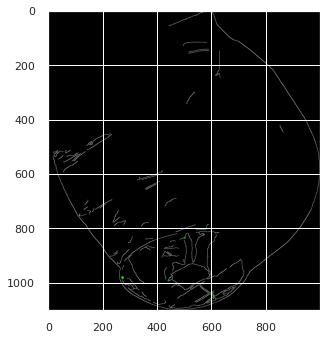

In [211]:
def show_keypoints(img_id, n_descriptors):
    # Loading image
    image = opencv_open_img(img_id)
    image = opencv_gaussian_filter(image)
    image = opencv_canny_filter(image)
    # Detector extraction
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(n_descriptors)
    kp = orb.detect(image, None)
    kp, des = orb.compute(image, kp)
    imageimg= np.uint8(image)
    img2 = cv2.drawKeypoints(image, kp, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()

show_keypoints('0a3b5fdf77a361c2d7d9b29c259b8c4e', 10)

In [217]:
def list_of_keypoints_coordinates(img_id, n_descriptors):
    my_img = opencv_open_img(img_id)
    my_img = opencv_gaussian_filter(my_img)
    my_img = opencv_canny_filter(my_img)
    # Detector extraction
    my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
    my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(n_descriptors)
    kp = orb.detect(my_img, None)
    coord, des = orb.compute(my_img, kp)
    coord = cv2.KeyPoint_convert(coord)
    return coord


def detectors_coordinates_df(df, n_clust, n_descr):
    detectors_df = pd.DataFrame(columns=['keypoints_x', 'keypoints_y', 'uniq_id', 'descriptor_id'])
    for i, img_id in enumerate(df['uniq_id']):
        detectors_list = list_of_keypoints_coordinates(img_id, n_descr)
        img_index = df.index[df['uniq_id']==img_id].values
        try:
            for j, keypoint in enumerate(detectors_list):
                keypoint = list(keypoint)
                keypoint.append(int(img_index))
                keypoint.append(j+1)
                keypoint = pd.Series(keypoint, index=detectors_df.columns)
                detectors_df.loc[detectors_df.shape[0]] = keypoint
        except TypeError:
            pass
    detectors_df['uniq_id'] = [int(element) for element in detectors_df['uniq_id']]
    return detectors_df


def list_of_keypoints_descriptors(img_id, n_descriptors, output_type):
    my_img = opencv_open_img(img_id)
    my_img = opencv_gaussian_filter(my_img)
    my_img = opencv_canny_filter(my_img)
    # Detector extraction
    my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2RGB)
    my_img = cv2.cvtColor(my_img, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(n_descriptors)
    kp = orb.detect(my_img, None)
    coord, des = orb.compute(my_img, kp)
    return des


def detectors_descriptors_df(df, n_clust, n_descr):
    detectors_df = pd.DataFrame(columns=list(range(0, 32)))
    detectors_df['uniq_id'] = []
    detectors_df['descriptor_id'] = [] 
    for i, img_id in enumerate(df['uniq_id']):
        detectors_list = list_of_keypoints_descriptors(img_id, n_descr)
        img_index = df.index[df['uniq_id']==img_id].values
        try:
            for j, descriptor in enumerate(detectors_list):
                descriptor = list(descriptor)
                descriptor.append(int(img_index))
                descriptor.append(j+1)
                descriptor = pd.Series(descriptor, index=detectors_df.columns)
                detectors_df.loc[detectors_df.shape[0]] = descriptor 
        except TypeError:
            pass
    detectors_df['uniq_id'] = [int(element) for element in detectors_df['uniq_id']]
    return detectors_df


def kmean_detectors_clustering(detectors_df):
    k_means = KMeans(n_clusters=n_clust)
    kmeans_df = detectors_df.drop('uniq_id', axis=1).drop('descriptor_id', axis=1)
    k_means.fit(kmeans_df)
    detectors_df['labels'] = k_means.labels_
    detectors_df = detectors_df[['uniq_id', 'labels']]
    return detectors_df


def get_descriptors_weights_df(detectors_df, n_clust):
    # Creation of a dataframe to be concatened to the final dataframe and  used for clustering
    my_keys = list(range(0, n_clust))
    descriptors_weights_df = pd.DataFrame({'uniq_id':detectors_df['uniq_id'].unique()})
    descriptors_weights_df[my_keys] = np.nan * len(detectors_df)
    descriptors_weights_df.set_index('uniq_id', inplace=True)
    for uniq_id in detectors_df['uniq_id'].unique():
        temp_df = detectors_df[detectors_df['uniq_id']==uniq_id]
        temp_dict = dict(Counter(temp_df['labels']))
        temp_row = []
        for i in range(0, n_clust):
            keys_list = list(temp_dict.keys())
            if i in keys_list:
                temp_row.append(temp_dict[i])
            else:
                temp_row.append(0)
        descriptors_weights_df.loc[uniq_id] = temp_row
    return descriptors_weights_df


def merge_detectors(n_clust, n_descr, mode, df):
    descr_weights_df = create_detectors_df(n_clust, n_descr, mode)
    df = pd.merge(df, descr_weights_df,
                            left_index=True, right_index=True)
    return df


n_clust = 22
n_descr = 10
detectors_df = detectors_coordinates_df(items_df, n_clust, n_descr)
detectors_df = kmean_detectors_clustering(detectors_df)
detectors_df = get_descriptors_weights_df(detectors_df, n_clust)
merge_df = merge_detectors(items_df, n_clust, n_descr)
merge_df.set_index('uniq_id', inplace=True)
merge_df.head(3)

KeyboardInterrupt: ignored

In [ ]:
stop

In [ ]:
# Constitution of dataframe
col_list = list(merge_df.columns)[-22:]
descriptors_df = merge_df[col_list]
descriptors_df.index = merge_df.index
descriptors_df.sort_values(by=3, ascending=False).head(5)

In [ ]:
def compare_tsne_kmeans(df):
    embedded_df = TSNE(n_components=2).fit_transform(df)
    df_subset = pd.DataFrame(embedded_df[:, 0],
                            embedded_df[:, 1])
    kmeans = KMeans(n_clusters=22)
    kmeans.fit(df)
    df_subset['labels'] = list(kmeans.labels_)
    sns.scatterplot(data=df_subset,
                    x=list(df_subset.index),
                    y=list(df_subset[0]),
                    hue='labels', palette=sns.hls_palette(len(df_subset['labels'].unique())))

compare_tsne_kmeans(descriptors_df)

In [ ]:
# Comparison of k-means scores according to the number of detectors choosen
n_clust = 22
analysis_list = [2, 5, 10, 15, 20]
if True:
    inertia_dict = {}
    calinski_harabasz_dict = {}
    davies_bouldin_dict = {}
    for n_descr in analysis_list:
        print(n_descr)
        temp_df = merge_detectors(n_clust=n_clust,
                                  n_descr=n_descr,
                                  mode='coord',
                                  my_dataframe=items_df)
        # Constitution of dataframe
        col_list = list(temp_df.columns)[-n_clust:]
        descriptors_df = temp_df[col_list]
        # K-means instanciation and fitting
        kmeans_model = KMeans(n_clusters=n_clust).fit(descriptors_df)
        labels = kmeans_model.labels_
        inertia_dict[n_descr] = kmeans_model.inertia_
        ca_ha_dict[n_descr] = metrics.ca_ha_score(descriptors_df, labels)
        da_bo_dict[n_descr] = metrics.da_bo_score(descriptors_df, labels)

In [ ]:
# Display performances according inertia metric
if True:
    plt.title('Inertia according number of detectors')
    plt.xlabel('Number of detectors')
    plt.ylabel('Inertia')
    inertia_values = inertia_dict.values()
    plt.ylim(0, max(inertia_dict.values())*1.1)
    plt.plot(analysis_list,
             list(inertia_values))

In [ ]:
# Display performances according Calinski-Harabasz metric
if True:
    plt.title('Performances according Calinski-Harabasz metrics')
    plt.xlabel('Number of detectors')
    plt.ylabel('Score')
    calhar_values = calinski_harabasz_dict.values()
    plt.ylim(0, max(calinski_harabasz_dict.values())*1.1)
    plt.plot(analysis_list,
             list(calhar_values))

In [ ]:
# Display performances according Davies-Bouldin metric
if True:
    plt.title('Performances according Davies-Bouldin metrics')
    plt.xlabel('Number of detectors')
    plt.ylabel('Score')
    davbol_values = davies_bouldin_dict.values()
    plt.ylim(0, max(davies_bouldin_dict.values())*1.1)
    plt.plot(analysis_list,
             list(davbol_values))

In [ ]:
# Check the relevance of the groups found by k-means
merge_df.sort_values(by=0, ascending=False).head(5)

### 12 CNN

In [ ]:
if True:
def VGG16_predictions(df, i)
    img_id = df['uniq_id'].iloc[i]
    model = VGG16()
    img = load_img(PATH_PICTURE + img_id + '.jpg', target_size=(224, 224))
    img_arr = img_to_array(img)
    img_arr = img_arr.reshape((1,img_arr.shape[0],
                                                 img_arr.shape[1],
                                                 img_arr.shape[2]))
    img_arr = preprocess_input(img_arr)
    y = model.predict(img_arr)
    # Extract the 3 most probable classes
    predictions_dict = decode_predictions(y, top=3)[0]
    prediction_names = [element[1] for element in temp_dict]
    prediction_values = [round(element[2]*100, 1) for element in temp_dict]
    plt.title('Image N. {}'.format(img_id))
    plt.xlim((0, 100))
    plt.barh(y=keys_list,
            width=values_list)
    
VGG16_predictions(items_df, 7)

## E. Sauvegarde

In [ ]:
merge_df.to_csv(PATH+'merge_df.csv')

In [ ]:
!cp merge_df.csv PATH